In [1]:
import os, time, pickle, argparse, networks, utils
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from edge_promoting import edge_promoting

### Parameters

In [2]:
name='project_name'
#source data path
src_data='src_data_path'
#target data path
tgt_data='tgt_data_path'
#pre-trained VGG19 model path
vgg_model='pre_trained_VGG19_model_path/vgg19.pth'
#input channel for generator
in_ngc=3
#output channel for generator
out_ngc=3
#input channel for discriminator
in_ndc=3
#output channel for discriminator
out_ndc=1
batch_size=8
ngf=64
ndf=32
#the number of resnet block layer for generator
nb=8
#input size
input_size=256
train_epoch=50
pre_train_epoch=10
#Discriminator learning rate, default=0.0002
lrD=0.0002
#Generator learning rate, default=0.0002
lrG=0.0002
#lambda for content loss
con_lambda=10
#beta1 for Adam optimizer
beta1=0.5
#beta2 for Adam optimizer
beta2=0.999

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = True

In [4]:
device

device(type='cuda')

In [5]:
# results save path
if not os.path.isdir(os.path.join(name + '_results', 'Reconstruction')):
    os.makedirs(os.path.join(name + '_results', 'Reconstruction'))
if not os.path.isdir(os.path.join(name + '_results', 'Transfer')):
    os.makedirs(os.path.join(name + '_results', 'Transfer'))

In [6]:
#setup source and target folder
if not os.path.isdir(os.path.join('data',tgt_data,'train')):
    os.makedirs(os.path.join('data',tgt_data,'train'))
if not os.path.isdir(os.path.join('data',src_data,'train')):
    os.makedirs(os.path.join('data',src_data,'train'))
if not os.path.isdir(os.path.join('data',src_data,'test')):
    os.makedirs(os.path.join('data',src_data,'test'))

In [7]:
# edge-promoting
if not os.path.isdir(os.path.join('data', tgt_data, 'pair')):
    print('edge-promoting start!!')
    edge_promoting(os.path.join('data', tgt_data, 'train'), os.path.join('data', tgt_data, 'pair'))
else:
    print('edge-promoting already done')

edge-promoting already done


In [5]:
# data_loader
src_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
tgt_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader_src = utils.data_load(os.path.join('data', src_data), 'train', src_transform, batch_size, shuffle=True, drop_last=True)
train_loader_tgt = utils.data_load(os.path.join('data', tgt_data), 'pair', tgt_transform, batch_size, shuffle=True, drop_last=True)
test_loader_src = utils.data_load(os.path.join('data', src_data), 'test', src_transform, 1, shuffle=True, drop_last=True)

In [9]:
# network
G = networks.generator(in_ngc, out_ngc, ngf, nb)
D = networks.discriminator(in_ndc, out_ndc, ndf)
VGG = networks.VGG19(init_weights=vgg_model, feature_mode=True)
G.to(device)
D.to(device)
VGG.to(device)
G.train()
D.train()
VGG.eval()
print('---------- Networks initialized -------------')
utils.print_network(G)
utils.print_network(D)
utils.print_network(VGG)
print('-----------------------------------------------')

---------- Networks initialized -------------
generator(
  (down_convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): ReLU(inplace)
  )
  (resnet_blocks): Sequential(
    (0): resnet_block(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1_norm): InstanceNorm2d(256,

In [10]:
# loss
BCE_loss = nn.BCELoss().to(device)
L1_loss = nn.L1Loss().to(device)

In [11]:
# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lrG, betas=(beta1, beta2))
D_optimizer = optim.Adam(D.parameters(), lr=lrD, betas=(beta1, beta2))
G_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=G_optimizer, milestones=[train_epoch // 2, train_epoch // 4 * 3], gamma=0.1)
D_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=D_optimizer, milestones=[train_epoch // 2, train_epoch // 4 * 3], gamma=0.1)

pre_train_hist = {}
pre_train_hist['Recon_loss'] = []
pre_train_hist['per_epoch_time'] = []
pre_train_hist['total_time'] = []

### Pre-train

In [12]:
print('Pre-training start!')
start_time = time.time()
for epoch in range(pre_train_epoch):
    epoch_start_time = time.time()
    Recon_losses = []
    for x, _ in train_loader_src:
        x = x.to(device)

        # train generator G
        G_optimizer.zero_grad()

        x_feature = VGG((x + 1) / 2)
        G_ = G(x)
        G_feature = VGG((G_ + 1) / 2)

        Recon_loss = 10 * L1_loss(G_feature, x_feature.detach())
        Recon_losses.append(Recon_loss.item())
        pre_train_hist['Recon_loss'].append(Recon_loss.item())

        Recon_loss.backward()
        G_optimizer.step()

        break

    per_epoch_time = time.time() - epoch_start_time
    pre_train_hist['per_epoch_time'].append(per_epoch_time)
    print('[%d/%d] - time: %.2f, Recon loss: %.3f' % ((epoch + 1), pre_train_epoch, per_epoch_time, torch.mean(torch.FloatTensor(Recon_losses))))

total_time = time.time() - start_time
pre_train_hist['total_time'].append(total_time)
with open(os.path.join(name + '_results',  'pre_train_hist.pkl'), 'wb') as f:
    pickle.dump(pre_train_hist, f)

with torch.no_grad():
    G.eval()
    for n, (x, _) in enumerate(train_loader_src):
        x = x.to(device)
        G_recon = G(x)
        result = torch.cat((x[0], G_recon[0]), 2)
        path = os.path.join(name + '_results', 'Reconstruction', name + '_train_recon_' + str(n + 1) + '.png')
        plt.imsave(path, (result.cpu().numpy().transpose(1, 2, 0) + 1) / 2)
        if n == 4:
            break

    for n, (x, _) in enumerate(test_loader_src):
        x = x.to(device)
        G_recon = G(x)
        result = torch.cat((x[0], G_recon[0]), 2)
        path = os.path.join(name + '_results', 'Reconstruction', name + '_test_recon_' + str(n + 1) + '.png')
        plt.imsave(path, (result.cpu().numpy().transpose(1, 2, 0) + 1) / 2)
        if n == 4:
            break



Pre-training start!
[1/10] - time: 6.81, Recon loss: 24.140
[2/10] - time: 0.22, Recon loss: 26.363
[3/10] - time: 0.42, Recon loss: 26.182
[4/10] - time: 0.42, Recon loss: 24.677
[5/10] - time: 0.42, Recon loss: 23.091
[6/10] - time: 0.42, Recon loss: 25.020
[7/10] - time: 0.42, Recon loss: 24.514
[8/10] - time: 0.42, Recon loss: 22.543
[9/10] - time: 0.42, Recon loss: 21.546
[10/10] - time: 0.42, Recon loss: 22.108


In [13]:
train_hist = {}
train_hist['Disc_loss'] = []
train_hist['Gen_loss'] = []
train_hist['Con_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []
train_hist['Gen_loss_one_epoch']=[]
train_hist['Disc_loss_one_epoch']=[]
train_hist['Con_loss_one_epoch']=[]

In [ ]:
print('training start!')
start_time = time.time()
real = torch.ones(batch_size, 1, input_size // 4, input_size // 4).to(device)
fake = torch.zeros(batch_size, 1, input_size // 4, input_size // 4).to(device)
for epoch in range(train_epoch):
    epoch_start_time = time.time()
    G.train()
    G_scheduler.step()
    D_scheduler.step()
    Disc_losses = []
    Gen_losses = []
    Con_losses = []
    for (x, _), (y, _) in zip(train_loader_src, train_loader_tgt):
        e = y[:, :, :, input_size:]
        y = y[:, :, :, :input_size]
        x, y, e = x.to(device), y.to(device), e.to(device)

        # train D
        D_optimizer.zero_grad()

        D_real = D(y)
        D_real_loss = BCE_loss(D_real, real)

        G_ = G(x)
        D_fake = D(G_)
        D_fake_loss = BCE_loss(D_fake, fake)

        D_edge = D(e)
        D_edge_loss = BCE_loss(D_edge, fake)

        Disc_loss = D_real_loss + D_fake_loss + D_edge_loss
        Disc_losses.append(Disc_loss.item())
        train_hist['Disc_loss'].append(Disc_loss.item())

        Disc_loss.backward()
        D_optimizer.step()

        # train G
        G_optimizer.zero_grad()

        G_ = G(x)
        D_fake = D(G_)
        D_fake_loss = BCE_loss(D_fake, real)

        x_feature = VGG((x + 1) / 2)
        G_feature = VGG((G_ + 1) / 2)
        Con_loss = con_lambda * L1_loss(G_feature, x_feature.detach())

#         Gen_loss = D_fake_loss + Con_loss
#         Gen_loss = D_fake_loss
        Gen_loss = D_fake_loss + 0.5 * Con_loss

        Gen_losses.append(D_fake_loss.item())
        train_hist['Gen_loss'].append(D_fake_loss.item())
        Con_losses.append(Con_loss.item())
        train_hist['Con_loss'].append(Con_loss.item())

        Gen_loss.backward()
        G_optimizer.step()


    per_epoch_time = time.time() - epoch_start_time
    train_hist['per_epoch_time'].append(per_epoch_time)
    
    Gen_loss_avg = torch.mean(torch.FloatTensor(Gen_losses))
    Con_loss_avg = torch.mean(torch.FloatTensor(Con_losses))
    Disc_loss_avg =  torch.mean(torch.FloatTensor(Disc_losses))
    
    train_hist['Gen_loss_one_epoch'].append(Gen_loss_avg)
    train_hist['Disc_loss_one_epoch'].append(Disc_loss_avg)
    train_hist['Con_loss_one_epoch'].append(Con_loss_avg)
    
    print(
    '[%d/%d] - time: %.2f, Disc loss: %.3f, Gen loss: %.3f, Con loss: %.3f' % ((epoch + 1), train_epoch, per_epoch_time, Disc_loss_avg, Gen_loss_avg, Con_loss_avg))

    with torch.no_grad():
        G.eval()
        for n, (x, _) in enumerate(train_loader_src):
            x = x.to(device)
            G_recon = G(x)
            result = torch.cat((x[0], G_recon[0]), 2)
            path = os.path.join(name + '_results', 'Transfer', str(epoch+1) + '_epoch_' + name + '_train_' + str(n + 1) + '.png')
            plt.imsave(path, (result.cpu().numpy().transpose(1, 2, 0) + 1) / 2)
            if n == 4:
                break

        for n, (x, _) in enumerate(test_loader_src):
            x = x.to(device)
            G_recon = G(x)
            result = torch.cat((x[0], G_recon[0]), 2)
            path = os.path.join(name + '_results', 'Transfer', str(epoch+1) + '_epoch_' + name + '_test_' + str(n + 1) + '.png')
            plt.imsave(path, (result.cpu().numpy().transpose(1, 2, 0) + 1) / 2)
            if n == 4:
                break

        torch.save(G.state_dict(), os.path.join(name + '_results', 'generator_latest.pkl'))
        torch.save(D.state_dict(), os.path.join(name + '_results', 'discriminator_latest.pkl'))

total_time = time.time() - start_time
train_hist['total_time'].append(total_time)

print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), train_epoch, total_time))

training start!
[1/50] - time: 1239.92, Disc loss: 1.313, Gen loss: 1.846, Con loss: 8.588
[2/50] - time: 1239.15, Disc loss: 0.792, Gen loss: 2.150, Con loss: 6.918
[3/50] - time: 1239.31, Disc loss: 0.618, Gen loss: 2.665, Con loss: 7.291
[4/50] - time: 1238.95, Disc loss: 0.557, Gen loss: 2.914, Con loss: 7.643
[5/50] - time: 1238.71, Disc loss: 0.577, Gen loss: 2.784, Con loss: 7.788
[6/50] - time: 1238.82, Disc loss: 0.468, Gen loss: 3.021, Con loss: 8.066
[7/50] - time: 1238.73, Disc loss: 0.413, Gen loss: 3.151, Con loss: 8.266
[8/50] - time: 1238.63, Disc loss: 0.356, Gen loss: 3.365, Con loss: 8.512
[9/50] - time: 1238.43, Disc loss: 0.301, Gen loss: 3.653, Con loss: 8.766
[10/50] - time: 1238.35, Disc loss: 0.406, Gen loss: 3.578, Con loss: 9.021
[11/50] - time: 1238.73, Disc loss: 0.576, Gen loss: 2.986, Con loss: 8.877
[12/50] - time: 1238.84, Disc loss: 0.531, Gen loss: 3.078, Con loss: 9.016
[13/50] - time: 1238.53, Disc loss: 0.441, Gen loss: 3.349, Con loss: 9.114
[14/5

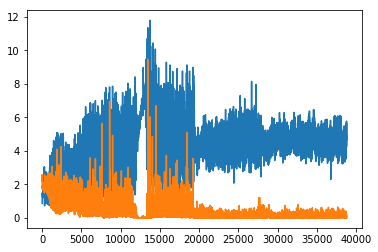

In [27]:
plt.plot(train_hist['Gen_loss'])
plt.plot(train_hist['Disc_loss'])

In [27]:
torch.save(G.state_dict(), os.path.join(name + '_results',  'generator_param.pkl'))
torch.save(D.state_dict(), os.path.join(name + '_results',  'discriminator_param.pkl'))
with open(os.path.join(name + '_results',  'train_hist.pkl'), 'wb') as f:
    pickle.dump(train_hist, f)

In [28]:
generator_view = torch.load(os.path.join(name + '_results',  'generator_param.pkl'))

In [34]:
D.state_dict()

OrderedDict([('convs.0.weight',
              tensor([[[[ 1.5837e-02,  5.5716e-03,  2.2361e-02],
                        [-4.1403e-03,  2.1237e-02,  1.7914e-03],
                        [-1.7184e-02,  1.9488e-02,  1.5258e-02]],
              
                       [[-2.4625e-02,  7.1820e-04,  2.2343e-02],
                        [ 1.4765e-02, -2.4119e-02,  9.5952e-03],
                        [ 4.8353e-02,  7.2604e-03,  1.6212e-02]],
              
                       [[-3.8617e-02, -2.2787e-02,  6.1015e-03],
                        [-1.8316e-02,  7.6806e-03,  9.7825e-03],
                        [-1.6106e-02,  9.1911e-04, -1.0556e-02]]],
              
              
                      [[[ 2.5714e-02, -2.1110e-02,  3.4113e-06],
                        [ 1.2102e-02,  1.1570e-02,  1.5014e-02],
                        [ 1.2348e-02, -5.8596e-03,  2.0600e-02]],
              
                       [[ 7.0174e-03, -8.1979e-03,  2.9815e-02],
                        [ 1.7954e-02,  1.98